<a href="https://colab.research.google.com/github/yubraaj11/Food-Recommendation-System/blob/master/Instacart_Recommendation_Predection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1**. `Preprocessed_Instacart` dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
csv_path = '/content/drive/MyDrive/Datasets/Preprocessed_instacart_v1.csv'

In [3]:
import pandas as pd
data = pd.read_csv(csv_path, index_col=0)
data

,order_dow,order_hour_of_day,product_id,aisle_id,department_id,target
0,0,0,577,48,1,1
1,0,0,1671,22,4,1
2,0,0,2880,110,4,1
3,0,0,513,101,3,1
4,0,0,1479,22,4,1
...,...,...,...,...,...,...
647405,6,23,276,107,16,0
647406,6,23,2778,3,19,0
647407,6,23,2745,50,17,0
647408,6,23,1948,78,16,0


In [4]:
data['department_id'].min(), data['department_id'].max()

(1, 21)

In [5]:
data['aisle_id'].min(), data['aisle_id'].max()


(1, 118)

In [6]:
!pip install deepctr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.8.0
    Uninstalling h5py-3.8.0:
      Successfully uninstalled h5py-3.8.0


In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, get_feature_names

In [8]:
sparse_features = ['order_dow', 'order_hour_of_day', 'product_id', 'aisle_id', 'department_id']
target = ['target']

In [9]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() + 1, embedding_dim=4)
                        for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}

In [11]:
train_model_input

{'order_dow': array([0, 4, 3, ..., 4, 5, 4]),
 'order_hour_of_day': array([ 7, 17, 16, ..., 17, 17, 13]),
 'product_id': array([ 814, 1478, 1202, ...,  695, 2136, 2037]),
 'aisle_id': array([100,  21,  96, ...,  77,  87,  28]),
 'department_id': array([ 2,  3, 18, ..., 15, 19,  6])}

# **1**. Classification: `Preprocessed_Instacart` dataset

In [12]:
from sklearn.metrics import log_loss, roc_auc_score

In [15]:
model_1 = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
# model_1
model_1.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "AUC", "accuracy"], )

history = model_1.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=20, verbose=2, validation_split=0.2, )
pred_ans = model_1.predict(test_model_input, batch_size=256)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

Epoch 1/20
1619/1619 - 15s - loss: 0.4453 - binary_crossentropy: 0.4451 - auc: 0.8533 - accuracy: 0.7895 - val_loss: 0.4321 - val_binary_crossentropy: 0.4317 - val_auc: 0.8637 - val_accuracy: 0.7967
Epoch 2/20
1619/1619 - 11s - loss: 0.4291 - binary_crossentropy: 0.4286 - auc: 0.8646 - accuracy: 0.7984 - val_loss: 0.4294 - val_binary_crossentropy: 0.4288 - val_auc: 0.8645 - val_accuracy: 0.7975
Epoch 3/20
1619/1619 - 10s - loss: 0.4263 - binary_crossentropy: 0.4256 - auc: 0.8666 - accuracy: 0.8000 - val_loss: 0.4293 - val_binary_crossentropy: 0.4284 - val_auc: 0.8657 - val_accuracy: 0.7987
Epoch 4/20
1619/1619 - 11s - loss: 0.4232 - binary_crossentropy: 0.4222 - auc: 0.8690 - accuracy: 0.8022 - val_loss: 0.4247 - val_binary_crossentropy: 0.4235 - val_auc: 0.8680 - val_accuracy: 0.8017
Epoch 5/20
1619/1619 - 11s - loss: 0.4183 - binary_crossentropy: 0.4169 - auc: 0.8729 - accuracy: 0.8047 - val_loss: 0.4242 - val_binary_crossentropy: 0.4227 - val_auc: 0.8687 - val_accuracy: 0.8012
Epoch

In [16]:
model_path = '/content/drive/MyDrive/Datasets/RecSys'
model_1.save(model_path)
print(f"Model Saved at path: {model_path}")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model Saved at path: /content/drive/MyDrive/Datasets/RecSys


In [17]:
from keras import models

In [18]:
loaded_model = models.load_model(model_path)

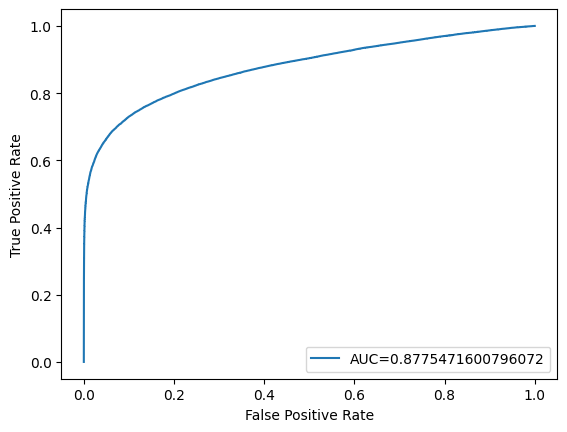

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

pred_ans = model_1.predict(test_model_input, batch_size=256)
fpr, tpr, _ = roc_curve(test[target].values, pred_ans)
auc = roc_auc_score(test[target].values, pred_ans)
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### The curve above ⬆️ is right bounded so the models is good at classification of data into categories

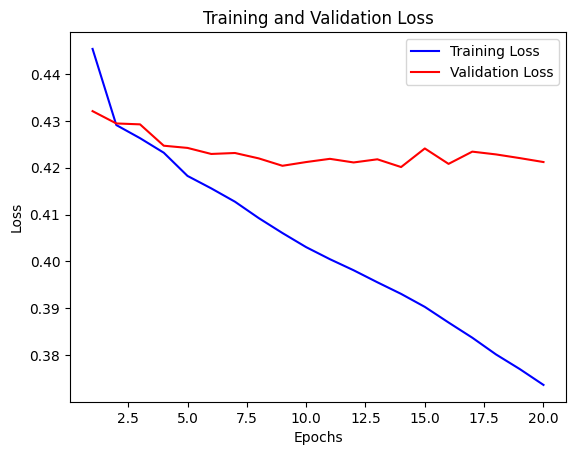

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Getting the dictionary of `product_id` as key and `aisle_id` and `department_id` as values

In [21]:
import pickle
dict_path = '/content/drive/MyDrive/Datasets/product_dict_v1.pkl'

with open(dict_path, 'rb') as file:
    loaded_dict = pickle.load(file)

print(loaded_dict)

{1973: [78, 16], 1050: [75, 4], 560: [94, 13], 1045: [83, 16], 1476: [83, 16], 1046: [110, 4], 2787: [75, 4], 1302: [110, 4], 2738: [50, 17], 2221: [75, 4], 2796: [104, 1], 2038: [29, 7], 861: [52, 14], 676: [110, 4], 913: [75, 4], 1872: [15, 4], 197: [75, 4], 1250: [22, 4], 78: [97, 19], 362: [54, 15], 1780: [35, 1], 1855: [18, 13], 1803: [49, 16], 2060: [90, 7], 1527: [97, 19], 14: [70, 7], 2480: [29, 7], 1381: [70, 7], 1981: [103, 7], 12: [48, 1], 2519: [108, 14], 1241: [104, 1], 1655: [76, 16], 1212: [24, 7], 448: [54, 15], 1254: [18, 13], 1171: [103, 7], 1502: [103, 7], 588: [21, 19], 2810: [75, 4], 1714: [104, 1], 478: [33, 16], 444: [80, 13], 1891: [84, 18], 2532: [110, 4], 2494: [75, 4], 2121: [56, 19], 2561: [22, 4], 1995: [59, 7], 1479: [22, 4], 239: [22, 4], 1515: [24, 7], 1717: [75, 4], 1359: [101, 3], 1271: [88, 20], 1435: [76, 16], 481: [22, 4], 1114: [98, 16], 716: [117, 9], 518: [75, 4], 1526: [110, 4], 2416: [34, 1], 2768: [34, 1], 2350: [96, 12], 2248: [20, 16], 2878:

In [22]:
loaded_dict.get(1478)

[90, 7]

# Recommending to user based on the day and hour provided by user `Context Aware Recommendation`

In [23]:
day = int(input('Enter day of week 0-6: '))
hour = int(input('Enter hour of day 0-23: '))

Enter day of week 0-6: 5
Enter hour of day 0-23: 9


In [24]:
import numpy as np

bigger_dict = {
    'order_dow': [],
    'order_hour_of_day': [],
    'product_id': [],
    'aisle_id': [],
    'department_id': []
}

for product_id, (aisle_id, department_id) in loaded_dict.items():
    bigger_dict['order_dow'].append(day)
    bigger_dict['order_hour_of_day'].append(hour)
    bigger_dict['product_id'].append(product_id)
    bigger_dict['aisle_id'].append(aisle_id)
    bigger_dict['department_id'].append(department_id)

for key in bigger_dict:
    bigger_dict[key] = np.array(bigger_dict[key])

print(bigger_dict)

{'order_dow': array([5, 5, 5, ..., 5, 5, 5]), 'order_hour_of_day': array([9, 9, 9, ..., 9, 9, 9]), 'product_id': array([1973, 1050,  560, ...,  443,  842,  541]), 'aisle_id': array([78, 75, 94, ..., 10, 34, 86]), 'department_id': array([16,  4, 13, ..., 17,  1,  7])}


In [25]:
pred_ans_1 = loaded_model.predict(bigger_dict, batch_size=2965)
print(pred_ans_1)

1/1 [==============================] - 0s 262ms/step
[[0.22502007]
 [0.993243  ]
 [0.5052459 ]
 ...
 [0.13211475]
 [0.19317836]
 [0.11682367]]


In [26]:
pred_ans = model_1.predict(bigger_dict, batch_size=2965)
print(pred_ans)

[[0.22502007]
 [0.993243  ]
 [0.5052459 ]
 ...
 [0.13211475]
 [0.19317836]
 [0.11682367]]


In [27]:
p_score = {}

for key, value in zip(loaded_dict.keys(), pred_ans):
    p_score[key] = value

print(p_score)

{1973: array([0.22502007], dtype=float32), 1050: array([0.993243], dtype=float32), 560: array([0.5052459], dtype=float32), 1045: array([0.24790631], dtype=float32), 1476: array([0.83673143], dtype=float32), 1046: array([0.91126394], dtype=float32), 2787: array([0.99347687], dtype=float32), 1302: array([0.13754705], dtype=float32), 2738: array([0.2643584], dtype=float32), 2221: array([0.98090196], dtype=float32), 2796: array([0.13921967], dtype=float32), 2038: array([0.08508797], dtype=float32), 861: array([0.11051844], dtype=float32), 676: array([0.55645484], dtype=float32), 913: array([0.16511607], dtype=float32), 1872: array([0.87699604], dtype=float32), 197: array([0.09694482], dtype=float32), 1250: array([0.17929047], dtype=float32), 78: array([0.1475648], dtype=float32), 362: array([0.16193993], dtype=float32), 1780: array([0.6537729], dtype=float32), 1855: array([0.38449198], dtype=float32), 1803: array([0.557145], dtype=float32), 2060: array([0.22778489], dtype=float32), 1527: a

In [28]:
sorted_items = sorted(p_score.items(), key=lambda x: x[1], reverse=True)

top_10 = sorted_items[:10]

for key, value in top_10:
    print(key, value)

1524 [1.]
2451 [1.]
2656 [1.]
1264 [1.]
517 [0.99999994]
1713 [0.9999999]
2846 [0.9999999]
2016 [0.9999998]
1854 [0.99999976]
1170 [0.9999997]


In [29]:
instacart_path = '/content/drive/MyDrive/Datasets/Instacart_original.csv'
instacart_df = pd.read_csv(instacart_path, index_col=0)
# instacart_df

In [30]:
print(" ***************Recommending*************** \n")

for key, value in top_10:
    # print(key)
    product_name = instacart_df.loc[instacart_df['product_id'] == key, 'product_name'].iloc[0]
    # product_name = product_name.loc[0, 'product_name']

    print(f"Product Name: {product_name} ---------- score: {value}")

 ***************Recommending*************** 

Product Name: Freshly Shaved Parmesan Cheese ---------- score: [1.]
Product Name: Fennel ---------- score: [1.]
Product Name: Elbow Macaroni Pasta ---------- score: [1.]
Product Name: Multigrain Sandwich Bread ---------- score: [1.]
Product Name: Ancient Grain Granola Cranberry Pecan ---------- score: [0.99999994]
Product Name: Honey Bunches of Oats Honey Roasted Cereal ---------- score: [0.9999999]
Product Name: Mandarin Oranges ---------- score: [0.9999999]
Product Name: Apple Pie Fruit & Nut Food Bar ---------- score: [0.9999998]
Product Name: Organic Stage 2 Peaches & Bananas Baby Food ---------- score: [0.99999976]
Product Name: Rich Taste Extra Virgin Olive Oil ---------- score: [0.9999997]
